In [979]:
import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations
from dataclasses import dataclass
import json
from typing import Any, Union, Optional
from papermodels.paper import annotations, fdf, plot
from papermodels.db.data_model import Annotation
from shapely.geometry import GeometryCollection, Polygon, Point
from shapely.ops import voronoi_diagram
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt, voronoi_polygons

from papermodels.paper.annotations import scale_annotations, filter_annotations, annotations_to_shapely

from shapely.geometry import MultiPolygon


# Constants
FILE_NAME = 'shearwall_data_R3.xlsx'
SHEET_NAME = 'SW_info'
LONGEST_DIM_NS_CELL = 'J10'
LONGEST_DIM_EW_CELL = 'J11'

#--------------------------------------------------------------------------------
# Functions
#--------------------------------------------------------------------------------

def load_annotations(file_list: list[str], scale_factor: Optional[float] = None, labels: Optional[list[str]] = None) -> dict[str, list[Annotation]]:
    
    """
    Returns a dict whose keys are each file name in 'file_list' and values are a list
    of annotations found in the files. If 'scale_factor' is specified, the resulting
    annotation geometries are scaled by 'scale_factor'.
    'labels' - Labels to be used as dict keys for each file in 'file_list'
    
    """
    annot_data = {}
    for idx, file_name in enumerate(file_list):
        annots = fdf.read_annotations(file_name)
        if scale_factor is not None:
            annots = annotations.scale_annotations(annots, scale=scale_factor)
        if labels is not None:
            if len(labels) != len(file_list):
                raise ValueError(f"Length of labels must match length file list. {len(file_list)=}, {len(labels)=}")
            annot_data.update({labels[idx]: annots})
    return annot_data


def extract_wall_data(sheet, start_col, id_col, length_col, height_col, x_col, y_col):
    """Extracts wall data from Excel and returns lists of attributes."""
    last_row = sheet.range(f'{start_col}{sheet.cells.last_cell.row}').end('up').row
    num_walls = int(sheet.range(f'{start_col}{last_row}').value)
    start_row = last_row - num_walls

    walls, lengths, heights, x_list, y_list = [], [], [], [], []
    for row in range(start_row + 1, start_row + 1 + num_walls):
        wall = {
            'id': sheet.range(f'{id_col}{row}').value,
            'length': sheet.range(f'{length_col}{row}').value,
            'height': sheet.range(f'{height_col}{row}').value,
            'x': sheet.range(f'{x_col}{row}').value,
            'y': sheet.range(f'{y_col}{row}').value,
        }
        walls.append(wall)
        lengths.append(wall['length'])
        heights.append(wall['height'])
        x_list.append(wall['x'])
        y_list.append(wall['y'])
    return walls, lengths, heights, x_list, y_list

def calculate_center_of_mass(lengths, coords):
    """Calculates the center of mass for a set of walls."""
    total_length = sum(lengths)
    com = sum(length * coord for length, coord in zip(lengths, coords)) / total_length
    return com

def calculate_normalized_lengths(lengths):
    """Calculates normalized lengths."""
    total_length = sum(lengths)
    return [length / total_length for length in lengths]

def calculate_m_torsion(lengths, longest_dimension):
    """Calculates torsion values for walls."""
    return [0.1 * longest_dimension for _ in lengths]

def calculate_rigidity(lengths, coords, com):
    """Calculates rigidity-related values for walls."""
    d_list = [abs(com - coord) for coord in coords]
    kdx_list = [length * d**2 for length, d in zip(lengths, d_list)]
    Jp = sum(kdx_list)
    return d_list, Jp

def calculate_v_total(normalized_lengths, torsion_list, k_list, Jp):
    """Calculates the total shear distribution for walls."""
    return [
        norm_length + (tor * k) / Jp
        for norm_length, tor, k in zip(normalized_lengths, torsion_list, k_list)
    ]

def plot_shear_wall_layout(ax, x_list, y_list, lengths, color, label_prefix):
    """Plots shear walls in a given direction."""
    for i, (x, y, length) in enumerate(zip(x_list, y_list, lengths)):
        if color == 'blue':  # Vertical (north-south)
            ax.plot([x, x], [y, y + length], label=f"{label_prefix} Wall {i+1}", color=color)
        else:  # Horizontal (east-west)
            ax.plot([x, x + length], [y, y], label=f"{label_prefix} Wall {i+1}", color=color)


def calculate_center_of_mass_with_floor(weights, centers, floor_weight, floor_center):
    """
    Calculates the center of mass including wall weights and floor diaphragm weight.
    
    Parameters:
    - weights: List of wall weights.
    - centers: List of wall center coordinates (X or Y).
    - floor_weight: Total weight of the floor diaphragm.
    - floor_center: Coordinate of the floor diaphragm center (X or Y).
    
    Returns:
    - Combined center of mass (X or Y coordinate) including the floor diaphragm.
    """
    # Total weight (walls + floor)
    total_wall_weight = sum(weights)
    total_weight = total_wall_weight + floor_weight
    
    # Center of mass for walls
    wall_com = sum(weight * center for weight, center in zip(weights, centers)) / total_wall_weight
    
    # Combined center of mass (walls + floor)
    combined_com = (total_wall_weight * wall_com + floor_weight * floor_center) / total_weight
    return combined_com


def calculate_wall_weights(lengths, heights, weight_per_unit_area=0.48):
    """
    Calculates the weight of walls based on their length, height, and weight per unit area.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - weight_per_unit_area: Weight per unit area (default is 0.48 kPa).
    
    Returns:
    - List of wall weights.
    """
    wall_weights = []
    for length, height in zip(lengths, heights):
        area = length * height  # Area of the wall
        weight = area * weight_per_unit_area  # Weight of the wall
        wall_weights.append(weight)
    return wall_weights


def calculate_center_of_rigidity_simple(lengths, heights, coords):
    """
    Calculates the center of rigidity assuming stiffness is proportional to length × height.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - coords: List of coordinates (X or Y).
    
    Returns:
    - Center of rigidity (X or Y coordinate).
    """
    stiffnesses = [length * height for length, height in zip(lengths, heights)]
    total_stiffness = sum(stiffnesses)
    rigidity_center = sum(stiffness * coord for stiffness, coord in zip(stiffnesses, coords)) / total_stiffness
    return rigidity_center

def calculate_wall_centers(start_coords, lengths, axis='y'):
    """
    Calculates the center coordinates for walls.
    
    Parameters:
    - start_coords: List of starting coordinates (X or Y).
    - lengths: List of wall lengths.
    - axis: 'x' or 'y', indicating which axis the wall centers are calculated for.
    
    Returns:
    - List of center coordinates.
    """
    centers = [start + (length / 2) for start, length in zip(start_coords, lengths)]
    return centers

def calculate_center_of_rigidity_relative(lengths, heights, centers):
    """
    Calculates the center of rigidity using relative rigidity approach.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - centers: List of center coordinates (X or Y).
    
    Returns:
    - Center of rigidity (X or Y coordinate).
    """
    relative_stiffnesses = [length * height for length, height in zip(lengths, heights)]
    total_stiffness = sum(relative_stiffnesses)
    rigidity_center = sum(stiffness * center for stiffness, center in zip(relative_stiffnesses, centers)) / total_stiffness
    return rigidity_center

#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------


# Workbook and Sheet Setup
wb = xw.Book(FILE_NAME)
sheet = wb.sheets[SHEET_NAME]
ws = sheet



#--------------------------------------------------------------------------------
# Extract required data from excel
#--------------------------------------------------------------------------------


# Extract Data for North-South and East-West Walls
walls_ns, lengths_ns, heights_ns, x_ns, y_ns = extract_wall_data(sheet, 'D', 'C', 'E', 'F', 'G', 'H')
walls_ew, lengths_ew, heights_ew, x_ew, y_ew = extract_wall_data(sheet, 'P', 'O', 'Q', 'R', 'S', 'T')


# Extract floor dimensions from Excel
floor_length = sheet.range('J10').value  # Replace 'J12' with the actual cell for floor length
floor_width = sheet.range('J11').value  # Replace 'K12' with the actual cell for floor width
floor_weight = sheet.range('J23').value  # Replace 'L12' with the actual cell for floor weight (optional)


#-------------------------------------------------------------------------------------------------------------------------
# Calculations
#-------------------------------------------------------------------------------------------------------------------------

# Calculate floor center coordinates
floor_center_x = floor_length / 2
floor_center_y = floor_width / 2

# Example usage with extracted wall data
# Assuming lengths_ns and heights_ns are lists of lengths and heights for NS walls
wall_weights_ns = calculate_wall_weights(lengths_ns, heights_ns)

# Assuming lengths_ew and heights_ew are lists of lengths and heights for EW walls
wall_weights_ew = calculate_wall_weights(lengths_ew, heights_ew)


# Calculate Wall Centers
y_centers_ns = calculate_wall_centers(y_ns, lengths_ns, axis='y')
x_centers_ew = calculate_wall_centers(x_ew, lengths_ew, axis='x')



# Calculate CoM with Floor
com_x_with_floor = calculate_center_of_mass_with_floor(wall_weights_ns, x_centers_ew, floor_weight, floor_center_x)
com_y_with_floor = calculate_center_of_mass_with_floor(wall_weights_ew, y_centers_ns, floor_weight, floor_center_y)





# Calculate CoR for East-West Walls (x_cr) and North-South Walls (y_cr)
x_cr = calculate_center_of_rigidity_relative(lengths_ew, heights_ew, x_centers_ew)  # X-axis CoR from EW walls
y_cr = calculate_center_of_rigidity_relative(lengths_ns, heights_ns, y_centers_ns)  # Y-axis CoR from NS walls





# The difference between the center of mass and center of rigidity to calculate additional torsional force due to offset or eccentricity

ns_offset_list = []
for idx,length_ns in enumerate(lengths_ns):
    ns_offset_list.append(abs(com_x_with_floor-x_cr))


ew_offset_list = []
for idx,length_ns in enumerate(lengths_ew):
    ew_offset_list.append(abs(com_y_with_floor-y_cr))


ns_offset = abs(com_x_with_floor-x_cr)
ew_offset = abs(com_y_with_floor-y_cr)





# Calculate Normalized Lengths (This is actually the force component based on wall length. It will be used later to distribute the total force in each wall)
norm_lengths_ns = calculate_normalized_lengths(lengths_ns)
norm_lengths_ew = calculate_normalized_lengths(lengths_ew)





# Calculate Torsion and Rigidity Values
longest_dim_ns = sheet.range(LONGEST_DIM_NS_CELL).value
longest_dim_ew = sheet.range(LONGEST_DIM_EW_CELL).value

m_tor_ns = calculate_m_torsion(lengths_ns, longest_dim_ns)
m_tor_ew = calculate_m_torsion(lengths_ew, longest_dim_ew)


# Element-wise addition for NS
total_m_tor_ns = [m + offset for m, offset in zip(m_tor_ns, ns_offset_list)]

# Element-wise addition for EW
total_m_tor_ew = [m + offset for m, offset in zip(m_tor_ew, ew_offset_list)]




d_x_ns, Jpx = calculate_rigidity(lengths_ns, x_ns, com_x_with_floor)
d_y_ew, Jpy = calculate_rigidity(lengths_ew, y_ew, com_y_with_floor)




# Calculate V_total for NS and EW directions
V_total_ns_list = calculate_v_total(norm_lengths_ns, m_tor_ns, d_x_ns, Jpx)
V_total_ew_list = calculate_v_total(norm_lengths_ew, m_tor_ew, d_y_ew, Jpy)




#----------------------------------------------------------------------------------------------------------------------------
# All output results to excel
#----------------------------------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------
# Output results to Excel
#--------------------------------------------------------------------------------
sheet.range('J13').value = com_x_with_floor
sheet.range('J14').value = com_y_with_floor


sheet.range('J16').value = x_cr  # X-coordinate of Center of Rigidity
sheet.range('J17').value = y_cr  # Y-coordinate of Center of Rigidity


# Output CoR results to Excel
sheet.range('N13').value = ns_offset  # X-coordinate of Center of Rigidity
sheet.range('N14').value = ew_offset  # Y-coordinate of Center of Rigidity


# Output Normalized Lengths to Excel
sheet.range('J29').options(transpose=True).value = norm_lengths_ns
sheet.range('V29').options(transpose=True).value = norm_lengths_ew


sheet.range('K29').options(transpose=True).value = total_m_tor_ns
sheet.range('W29').options(transpose=True).value = total_m_tor_ew


sheet.range('I29').options(transpose=True).value = d_x_ns
sheet.range('U29').options(transpose=True).value = d_y_ew
sheet.range('J19').value = Jpx
sheet.range('J20').value = Jpy

# Output V_total Results to Excel
sheet.range('L29').options(transpose=True).value = V_total_ns_list
sheet.range('X29').options(transpose=True).value = V_total_ew_list




#----------------------------------------------------------------------------------------------------------------------------
# Visualization
#----------------------------------------------------------------------------------------------------------------------------

# fig, ax = plt.subplots(figsize=(8, 6))
# plot_shear_wall_layout(ax, x_ns, y_ns, lengths_ns, color='blue', label_prefix='NS')
# plot_shear_wall_layout(ax, x_ew, y_ew, lengths_ew, color='red', label_prefix='EW')

# # Plot CoM and CoR
# ax.scatter(com_x_with_floor, com_y_with_floor, color='green', s=100, label='CoM')
# ax.scatter(x_cr, y_cr, color='orange', s=100, label='CoR')

# # Annotate CoM with coordinates
# ax.text(com_x_with_floor, com_y_with_floor, f'CoM ({com_x_with_floor:.2f}, {com_y_with_floor:.2f})',
#         fontsize=9, color='green', ha='right', va='bottom')

# # Annotate CoR with coordinates
# ax.text(x_cr, y_cr, f'CoR({x_cr:.2f}, {y_cr:.2f})',
#         fontsize=9, color='orange', ha='right', va='bottom')

# # Formatting the plot
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_title('Shear Wall Layout with CoM and CoR')
# # ax.legend(loc='upper right')
# ax.grid(True)
# ax.axis('equal')

# # Embed the plot into Excel
# ws.pictures.add(fig, name='ShearWallPlot', update=True, anchor=ws.range('C64'))
# plt.show()



In [980]:
# Extract floor diaphragm data 

project_dir = pathlib.Path.cwd() 

files = [
    project_dir/"Roof_data_r7.fdf"
]


## -----------------------------------------------------------------------------------
# Understand the scaling factor from inchs to m
## -----------------------------------------------------------------------------------
scaling_factor = ((1/72)*(1/(1/8))*25.4)/100

## -----------------------------------------------------------------------------------

annots_by_diaphragm = load_annotations(file_list = files, scale_factor=scaling_factor, labels=['diaphragm'])
annots_by_diaphragm




opening_area_properties={'line_weight': 1.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    opening_area_annots = annotations.filter_annotations(annots, opening_area_properties)


## -----------------------------------------------------------------------------------
# Change the origin of the diaphragm
## -----------------------------------------------------------------------------------
# scale_diaphragm = scale_annotations(annots = opening_area_annots, scale = 1 , paper_origin = (8.5*scaling_factor,34.5*scaling_factor))
# scale_diaphragm = scale_annotations(annots = opening_area_annots, scale = 1 , paper_origin = (8.5,34.5))
scale_diaphragm = scale_annotations(annots = opening_area_annots, scale = 1 , paper_origin = (0,0))
## -----------------------------------------------------------------------------------



panel_area = annotations.annotations_to_shapely(scale_diaphragm)
panel_area




# Combine all polygons into a MultiPolygon
multi_polygon = MultiPolygon(panel_area)

# Calculate the centroid of the MultiPolygon
centroid = multi_polygon.centroid
centroid_x, centroid_y = centroid.x, centroid.y
print(f"MultiPolygon Centroid: ({centroid_x:.2f}, {centroid_y:.2f})")

with open("multi_polygon.wkt", "w") as file:
    wkt.dump(multi_polygon, file)

MultiPolygon Centroid: (29.94, 34.44)


In [981]:
# Plot the roof diaphragm multipolygon with shear wall layout
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the shear walls
plot_shear_wall_layout(ax, x_ns, y_ns, lengths_ns, color='blue', label_prefix='NS')
plot_shear_wall_layout(ax, x_ew, y_ew, lengths_ew, color='red', label_prefix='EW')

# Plot the roof diaphragm multipolygon
for geom in multi_polygon.geoms:  # Handle each polygon in the MultiPolygon
    x, y = geom.exterior.xy  # Get exterior coordinates
    ax.plot(x, y, color='purple', linewidth=2, label='Roof Diaphragm')  # Plot the outline

# Plot the centroid of the multipolygon
ax.scatter(centroid_x, centroid_y, color='purple', s=100, label='Roof Centroid')

# Plot CoM and CoR
ax.scatter(com_x_with_floor, com_y_with_floor, color='green', s=100, label='CoM')
ax.scatter(x_cr, y_cr, color='orange', s=100, label='CoR')

# Annotate Roof Centroid
ax.text(centroid_x, centroid_y, f'Centroid ({centroid_x:.2f}, {centroid_y:.2f})',
        fontsize=10, color='purple', ha='left', va='bottom')

# Annotate CoM
ax.text(com_x_with_floor, com_y_with_floor, f'CoM ({com_x_with_floor:.2f}, {com_y_with_floor:.2f})',
        fontsize=9, color='green', ha='right', va='bottom')

# Annotate CoR
ax.text(x_cr, y_cr, f'CoR ({x_cr:.2f}, {y_cr:.2f})',
        fontsize=9, color='orange', ha='right', va='bottom')

# Formatting the plot
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Shear Wall Layout with Roof Diaphragm and Centroid')
# ax.legend()
ax.grid(True)
ax.axis('equal')

# Embed the plot into Excel
ws.pictures.add(fig, name='RoofDiaphragmShearWallPlot', update=True, anchor=ws.range('C64'))
plt.show()


(<Figure size 1200x1200 with 1 Axes>, <AxesSubplot: >)

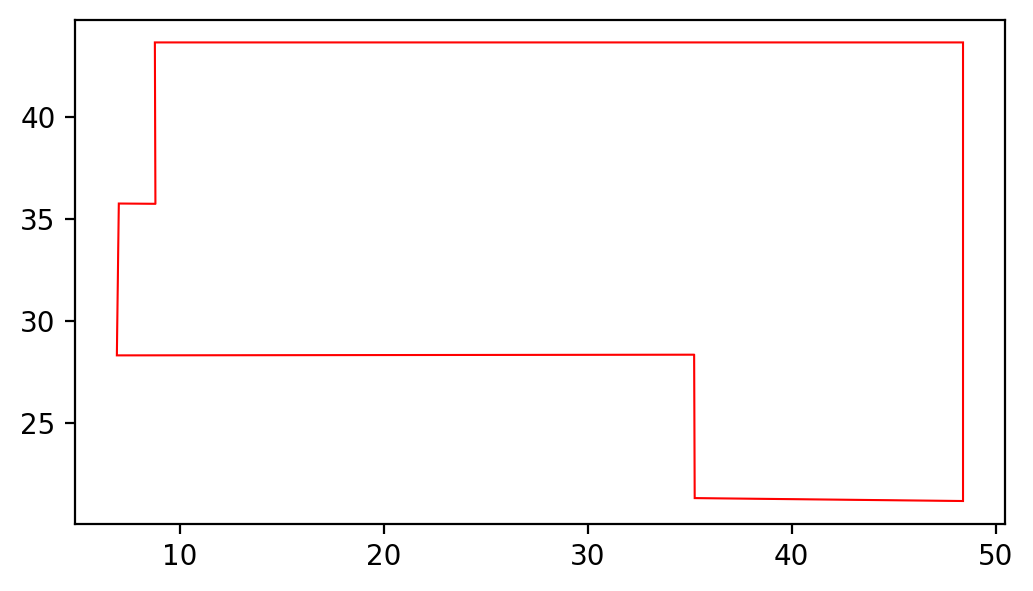

In [982]:
plot.plot_annotations(annots_by_diaphragm['diaphragm'], size=6, dpi=200)